# Baby Circadian Clocks

Parents of toddlers carefully guard and manage when and for how long their babies nap during the day and sleep at night. Not doing so could torpedo your night's sleep or Netflix plans and your next day's schedule. In fact, in our family, since my 2-year old son, Shaelo, naps and my 4-year old daughter, Danae, doesn't nap, a controlled circadian experiment unfolds every day. Naturally, I was curious to learn more. 

Here, I work with data from the C.S. Mott Children's Hospital in Ann Arbor, Michigan to answer 3 burning questions: 

**Question 1**: At what time do napping babies in the U.S. sleep at night?  
**Question 2**: Is night bedtime for napping babies in the U.S. later than that of non-napping babies?
<br>**Question 3**: Is sleep duration for napping babies in the U.S. different than that of non-napping babies? 

If you're curious, check out the original study on the differences in circadian clocks of napping and non-napping babies (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0125181).  

In this analysis, I formulate clear and focused questions that detail our target populations and parameters, hypotheses, alpha, and assumptions upfront. This part is super-important in order to perform a high quality analysis, draw the right conclusions, and not go down rabbit holes. I also walk through creating relevant dataframes for each analysis and applying numpy and statsmodels functions. I use simplifying assumptions of random, independent sampling normally distributed populations of nappers and non-nappers with similar variances. As you'll see from my initial plots below looking to understand the data that the sample is fairly small and that there is a bit of deviation from these assumptions. In a future post, I'll apply unpooled standard errors and non-parametric methods (e.g., Mann-Whitney) to test our hypotheses without these assumptions. 

To answer Question 1, I calculate a 95% confidence interval using both sm.stats.DescrStatsW and calculating lower and upper confidence bounds manually. To answer Question 2, I calculate a 1-sided P-value using t.cdf, t.sf, and sm.stats.ttest_ind (and halving the result). To answer Question 3, I calculate a 2-sided P-value using 1-t.cdf and sm.stats.ttest_ind. Lastly, I apply the Bonferroni Correction. "P hacking," including going into the subgroups or multiple hypothesis rabbit hole, increases the chance of observing rare events, or false positives (Type 1 Error). I apply the Bonferroni Correction to correct for this and raise the bar for rejecting our null hypothesis. Equally important, I walk through how to interpret the results from the confidence intervals and hypothesis tests to generate conclusions. 

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
import numpy as np
import scipy.stats.distributions as dist

In [106]:
pd.set_option("display.max_columns", 100)
sleep = pd.read_csv("https://raw.githubusercontent.com/UMstatspy/UMStatsPy/master/Course_2/nap_no_nap.csv")
sleep.head(5)

,id,sex,age (months),dlmo time,days napped,napping,nap lights outl time,nap sleep onset,nap midsleep,nap sleep offset,nap wake time,nap duration,nap time in bed,night bedtime,night sleep onset,sleep onset latency,night midsleep time,night wake time,night sleep duration,night time in bed,24 h sleep duration,bedtime phase difference,sleep onset phase difference,midsleep phase difference,wake time phase difference
0,1,female,33.7,19.24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.45,20.68,0.23,1.92,7.17,629.4,643.0,629.4,-1.21,-1.44,6.68,11.93
1,2,female,31.5,18.27,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.23,19.48,0.25,1.09,6.69,672.4,700.4,672.4,-0.96,-1.21,6.82,12.42
2,3,male,31.9,19.14,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.60,20.05,0.45,1.29,6.53,628.8,682.6,628.8,-0.46,-0.91,6.15,11.39
3,4,female,31.6,19.69,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.46,19.50,0.05,1.89,8.28,766.6,784.0,766.6,0.23,0.19,6.20,12.59
4,5,female,33.0,19.52,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.21,19.65,0.45,1.30,6.95,678.0,718.0,678.0,0.31,-0.13,5.78,11.43


In the variable "Napping", 1 represents nappers and 0 represents non-nappers. 

In [107]:
# Convert 'night bedtime' into hourly decimalized time so we can compare differences in minutes
sleep.loc[:,'night bedtime'] = np.floor(sleep['night bedtime'])*60 + np.round(sleep['night bedtime']%1,2 )*100

In [108]:
# Check shape of dataframe. It's 20 rows x 25 columns. 
sleep.shape

(20, 25)

In [109]:
# We're going to be using seaborn for plots, set style to darkgrid
sns.set_style("darkgrid")

A box plot of night bedtime for nappers and non-nappers shows that there is a difference in spread. For this analysis, I'm going to make the simplifying assumption that the variance in each group is the same and will use a pooled standard error. In a future post, I'll revisit this data and apply an unpooled standard error to test our hypotheses without this assumption. 

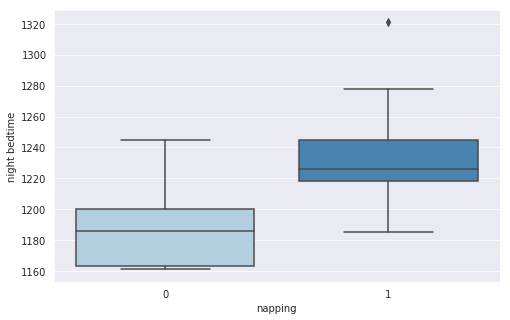

In [110]:
# Box plot of night bedtime
plt.figure(figsize=(8, 5))
sns.boxplot(sleep["napping"], sleep["night bedtime"], palette = "Blues")

In [111]:
# Create dataframes for bedtimes for nappers and non-nappers
nap_bedtime = sleep.loc[sleep.napping == 1, "night bedtime"]
no_nap_bedtime = sleep.loc[sleep.napping == 0, "night bedtime"]

A histogram shows that the distribution isn't exactly normal, with non-nappers having a right skew. The sample size of 20 is relatively small, but for the purposes of this analysis, I will make the simpifying assumption that the central limit theorom holds and the distribution is normal. In a future post, I'll revisit this data and try non-parametric methods (e.g., Mann-Whitney) to test our hypotheses without these assumptions.  

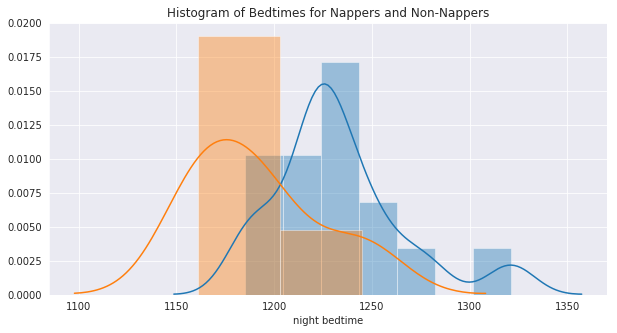

In [112]:
# Histogram of nappers' and non-nappers' night bedtime
plt.figure(figsize=(10, 5))
sns.distplot(nap_bedtime)
sns.distplot(no_nap_bedtime)
plt.title("Histogram of Bedtimes for Nappers and Non-Nappers")
plt.show()

## Question 1: At what time do napping babies in the U.S. fall sleep at night?   

#### Method 1: Calculate 95% CI using sm.stats.DescrStatsW

In [113]:
# Generate 95% confidence interval using (95% is the default)
sm.stats.DescrStatsW(nap_bedtime).tconfint_mean()

(1213.991362327341, 1252.1419710059922)

#### Method 2: Calculate lower and upper bounds for 95% CI manually

In [114]:
# Mean night bedtime for nappers
nap_mean_bedtime = nap_bedtime.mean()
print(nap_mean_bedtime)

1233.0666666666666


In [115]:
# Sample size of nappers
n = len(nap_bedtime)
print(n)

15


In [116]:
# Standard error of nappers
se = (nap_bedtime.std())/np.sqrt(n)
print(se)

8.893800230479801


In [117]:
# Calculate degrees of freedom
df = n-1
print(df)

14


In [118]:
# T star of nappers for 2-tail and df = 14 using stats.t.ppf (1-0.025, df)
t_star = stats.t.ppf(1-0.025, df)
print(t_star)

2.1447866879169273


In [119]:
# Lower confidence bound and upper confidence bound
lcb = nap_mean_bedtime - t_star * se
ucb = nap_mean_bedtime + t_star * se
(lcb,ucb)

(1213.991362327341, 1252.1419710059922)

As you can see that by using the automated sm.stats.DescrStatsW method or manually calculating the lower and upper confidence bounds I get the same result. After converting the decimalized time to hours, I can say that with 95% confidence, the true population mean night bedtime of napping babies in the U.S. is between 20:13 and 20:52. (Another way of saying this is that if I were to repeat this same statistical sample many times and generate confidence intervals, 95% of those intervals would include the true mean night bedtime of the all babies in the U.S.)

## Question 2: Is night bedtime for napping babies in the U.S. later than that of non-napping babies?
To answer this, I'll use a hypothesis test. Our null hypothesis is that the night bedtime is the same for both populations while our alternative hypothesis is that night bedtime is later for napping babies.

**Population 1**: All napping babies in the U.S.
<br>**Population 2**: All non-napping babies in the U.S.
<br>**Parameter**: $\mu_1 - \mu_2$, night bedtime in minutes
<br>**Null Hypothesis**: $\mu_1 - \mu_2$ = 0
<br>**Alternative Hypothesis**: $\mu_1 - \mu_2$ > 0 (1-sided test so we'll need a 1-sided p-value)
<br>**$\alpha$** = 0.025
<br>**Assumptions**: Random independent sample, variance similar among groups, roughly normal population distribution



#### Method 1: Calculate the 1-sided p-value using 1-t.cdf ("cumulative density function")

In [120]:
# Mean night bedtime for nappers
nap_mean_bedtime = nap_bedtime.mean()
print(nap_mean_bedtime)

1233.0666666666666


In [121]:
# Mean night bedtime for non-nappers
no_nap_mean_bedtime = no_nap_bedtime.mean()
print(no_nap_mean_bedtime)

1191.0


In [122]:
# Difference in mean night bedtimes in minutes
diff_mean = nap_mean_bedtime - no_nap_mean_bedtime
print(diff_mean)

42.066666666666606


In our sample, nappers fell asleep, on average, 42 minutes later than non-nappers.

In [123]:
# Sample size of nappers
n1 = len(nap_bedtime)
print(n1)

15


In [124]:
# Sample size of non-nappers
n2 = len(no_nap_bedtime)
print(n2)

5


In [125]:
# Standard deviation of night bedtime for nappers
s1 = nap_bedtime.std()
print(s1)

34.445540177143954


In [126]:
# Standard deviation of night bedtime for non-nappers
s2 = nap_bedtime.std()
print(s2)

34.445540177143954


As we highlighted above, we'll make the simplifying assumption that the variance in sleep time nappers and non-nappers is about the same so we can use the pooled standard error (in the future, we'll apply other methods without this assumption):  

$s.e.(\bar{X}_{nap} - \bar{X}_{no\ nap}) = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}(\frac{1}{n_1}+\frac{1}{n_2})}$

In [127]:
# Pooled standard error using the formula above
pooled_se = np.sqrt((((n1-1)*(s1**2)+(n2-1)*(s2**2))/(n1+n2-2))*((1/n1)+(1/n2)))
print(pooled_se)

17.787600460959602


In [128]:
# Calculate T-Statistic, or the number of standard error bars we are from the null hypothesis mean difference of 0
t_statistic = diff_mean/pooled_se
print(t_statistic)

2.3649433075020396


In [129]:
# Calculate degrees of freedom. Since we're using two samples, we'll subtract 2
df = n1 + n2 - 2
print(df)

18


In [130]:
# Calculate 1-sided p-value. In Question 3 further below, I'll calculate a 2-sided p-value.
p_value = 1-t.cdf(t_statistic, df)
print(p_value)

0.014734030327685166


#### Method 2: Calculate p-value using t.sf ("survival function"), which is another way of calculating a 1-sided p-value instead of using 1-t.cdf

In [131]:
# Calculate the 1-sided p-value using t.sf(T-statistic, df)
p_value = t.sf(t_statistic, df)
print(p_value)

0.014734030327685109


#### Method 3: Calculate the p-value using sm.stats.ttest_ind

In [132]:
# Calculate T-statistic and P-value automatically using sm.stats.ttest_ind. Note, however, these values are for a 2-sided test.
# In order to get the 1-sided p-value, which we need here, we simply multiply the result by 0.5. 

print("T-statistic, P-value, df")
sm.stats.ttest_ind(nap_bedtime, no_nap_bedtime)

T-statistic, P-value, df


(2.367160052079275, 0.029334902861805394, 18.0)

In [133]:
# Calculate 1-sided P-value, which is what we need here for our hypothesis test 
one_sided_p = 0.5 * 0.0293349
print(one_sided_p)

0.01466745


All three methods generate the same p-value of 0.0147, meaning that, if our null hypothesis is true (nappers sleep at the same time as non-nappers), there's only a 1.47% probability we would have gotten a difference like this from our statistical sample. 

Our p-value is is less than our $\alpha$ = 0.025, meaning that, based on our evidence, we can reject our null hypothesis and say that the bedtime of napping babies in the U.S. is significantly later than that of non-napping babies (in fact, 42 minutes later in our sample).

## Question 3: Is sleep duration for napping babies in the U.S. different than that of non-napping babies? 


To answer this, I'll use a hypothesis test. Our null hypothesis is that the night sleep duration is the same for both populations while our alternative hypothesis is that night sleep duration is different for the two populations.

**Population 1**: All napping babies in the U.S.
<br>**Population 2**: All non-napping babies in the U.S.
<br>**Parameter**: $\mu_1 - \mu_2$, night sleep duration in minutes
<br>**Null Hypothesis**: $\mu_1 - \mu_2$ = 0
<br>**Alternative Hypothesis**: $\mu_1 - \mu_2$ $\neq$ 0 (2-sided test so we'll need a 2-sided p-value)
<br>**$\alpha$** = 0.05
<br>**Assumptions**: Random independent sample, variance similar among groups, roughly normal population distribution

#### Method 1: Calculate the 2-sided p-value using t.cdf ("cumulative density function")

In [149]:
# First, let's create new dataframes for night sleep duration for nappers and non-nappers
nap_sleep = sleep.loc[sleep.napping == 1, "night sleep duration"]
no_nap_sleep = sleep.loc[sleep.napping == 0, "night sleep duration"]

In [153]:
# Mean night sleep duration for nappers
nap_mean_sleep = nap_sleep.mean()
print(nap_mean_sleep)

606.272


In [152]:
# Mean night sleep duration for non-nappers
no_nap_mean_sleep = no_nap_sleep.mean()
print(nap_mean_sleep)

675.04


In [154]:
# Difference in mean night bedtimes in minutes
diff_mean = no_nap_mean_sleep - nap_mean_sleep
print(diff_mean)

68.76799999999992


In our sample, non-nappers slept, on average, 69 minutes longer at night than did nappers. 

In [155]:
# Sample size of nappers
n1 = len(nap_sleep)
print(n1)

15


In [156]:
# Sample size of non-nappers
n2 = len(no_nap_sleep)
print(n2)

5


In [157]:
# Standard deviation of 24 hour sleep for nappers
s1 = nap_sleep.std()
print(s1)

43.858825174807016


In [158]:
# Standard deviation of 24 hour sleep for non-nappers
s2 = no_nap_sleep.std()
print(s2)

56.169635925471354


In [159]:
# Pooled standard error
pooled_se = np.sqrt((((n1-1)*(s1**2)+(n2-1)*(s2**2))/(n1+n2-2))*((1/n1)+(1/n2)))
print(pooled_se)

24.20604872065383


In [160]:
# Calculate T-Statistic, or the number of standard error bars we are from the null hypothesis mean difference of 0
t_statistic = diff_mean/pooled_se
print(t_statistic)

2.8409428070482057


In [161]:
# Calculate degrees of freedom. Since we're using two samples, we'll subtract 2
df = n1 + n2 - 2
print(df)

18


In [162]:
# Calculate 2-sided p-value using 1-t.cdf(np.abs(T-statistic), df) * 2
p_value = (1-t.cdf(np.abs(t_statistic), df))*2
print(p_value)

0.010840884590074484


#### Method 2: Calculate the p-value using sm.stats.ttest_ind

In [163]:
# Calculate T-statistic and 2-sided P-value automatically using sm.stats.ttest_ind.

print("T-statistic, P-value, df")
sm.stats.ttest_ind(nap_sleep, no_nap_sleep)

T-statistic, P-value, df


(-2.84094280704821, 0.010840884590074436, 18.0)

Both methods generate a P-value of 0.01084, meaning that, if our null hypothesis is true (nappers sleep the same amount of time at night as non-nappers), there's only a 1.08% probability we would have gotten a difference in night sleep duration like the one we got from our statistical sample. 

Our p-value is less than our $\alpha$ = 0.05, meaning, that based on our evidence, we can reject our null hypothesis and say that night sleep duration is significantly different for napping babies in the U.S. than non-napping babies (in fact, 69 minutes longer for non-nappers in our sample).  

## Bonferroni Correction

Performing multiple hypotheses increases the chance of observing rare events, or false positives (Type 1 Error), when making comparisons. The Bonferroni Correction corrects for this and raises the bar for rejecting the null by generating a corrected $\alpha$, dividing our original $\alpha$ by the number of hypotheses, in our case 2. 

In [148]:
alpha = 0.025
num_hyp = 2
benf_correction = alpha / num_hyp
print(benf_correction)

0.0125


For our 1st hypothesis (Question 2), our p-value of 0.0147 is now greater than our corrected $\alpha$ of 0.0125. Therefore, unlike our initial conclusion, we would fail to reject our null hypothesis and say that napping babies do not fall asleep at a later time than non-napping babies.  

In [164]:
alpha = 0.05
num_hyp = 2
benf_correction = alpha / num_hyp
print(benf_correction)

0.025


For our 2nd hypothesis (Question 3), our p-value of 0.0108 is still less than our corrected $\alpha$ of 0.025. Therefore, we sould stick with our initial conclusion and reject our null hypothesis and say that non-napping babies in the U.S. sleep for 69 minutes longer at night than do napping babies in the U.S. 